In [1]:
# Connecting to Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

In [3]:
import re
import string
import gzip
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as pyplot
from pandas import option_context
from sklearn import preprocessing
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.ensemble  import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score,classification_report,confusion_matrix
from IPython.core.interactiveshell import InteractiveShell  
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [6]:
# Reading Data
meta_health = getDF('/content/drive/MyDrive/Health_Data/meta_Health_and_Personal_Care.json.gz')
meta_health.head(3)

asin                                        description  \
0  0077614992            This is an example product description.   
1  0615208479  By now we all know the benefits of exercise fo...   
2  0615269990  What's wrong with your patient?Do all the symp...   

                                     title  \
0  Principles of Mgmt + Oper-CSUF Custom C   
1         Brain Fitness Exercises Software   
2                            Occam's Razor   

                                               imUrl  \
0  http://ecx.images-amazon.com/images/I/51G%2BRq...   
1  http://ecx.images-amazon.com/images/I/41kbZB04...   
2  http://ecx.images-amazon.com/images/I/51fH-ABe...   

                                             related  \
0  {'also_bought': ['0471730726', '0132834871', '...   
1                                                NaN   
2  {'also_bought': ['1935660152', '0071743979', '...   

                             salesRank  \
0   {'Health & Personal Care': 168429}   
1  {'Health & Personal Care': 1346973}   
2             {'Toys & Games': 110575}   

                                          categories  price brand  
0                         [[Health & Personal Care]]    NaN   NaN  
1          [[Health & Personal Care, Personal Care]]    NaN   NaN  
2  [[Health & Personal Care, Personal Care, Shavi...  34.99   NaN

In [7]:
# Reading Data
review_health = getDF('/content/drive/MyDrive/Health_Data/reviews_Health_and_Personal_Care.json.gz')
review_health.head(3)

reviewerID        asin    reviewerName helpful  \
0   ARMDSTEI0Z7YW  0077614992            dodo  [0, 0]   
1   A3FYN0SZYWN74  0615208479  Marilyn Mitzel  [0, 0]   
2  A2J0WRZSAAHUAP  0615269990          icu-rn  [0, 0]   

                                          reviewText  overall  \
0  This book was a requirement for a college clas...      5.0   
1  This is a great gift for anyone who wants to h...      5.0   
2  Very helpful in learning about different disea...      5.0   

                         summary  unixReviewTime   reviewTime  
0                          great      1360886400  02 15, 2013  
1  AMAZING HOW QUICKLY IT WORKS!      1228089600   12 1, 2008  
2                      Must have      1396742400   04 6, 2014

In [8]:
# Merging Data
merge_data = pd.merge(review_health,meta_health,on='asin',how='inner')

In [9]:
# Data Head
merge_data.head(2)

reviewerID        asin    reviewerName helpful  \
0  ARMDSTEI0Z7YW  0077614992            dodo  [0, 0]   
1  A3FYN0SZYWN74  0615208479  Marilyn Mitzel  [0, 0]   

                                          reviewText  overall  \
0  This book was a requirement for a college clas...      5.0   
1  This is a great gift for anyone who wants to h...      5.0   

                         summary  unixReviewTime   reviewTime  \
0                          great      1360886400  02 15, 2013   
1  AMAZING HOW QUICKLY IT WORKS!      1228089600   12 1, 2008   

                                         description  \
0            This is an example product description.   
1  By now we all know the benefits of exercise fo...   

                                     title  \
0  Principles of Mgmt + Oper-CSUF Custom C   
1         Brain Fitness Exercises Software   

                                               imUrl  \
0  http://ecx.images-amazon.com/images/I/51G%2BRq...   
1  http://ecx.images-amazon.com/images/I/41kbZB04...   

                                             related  \
0  {'also_bought': ['0471730726', '0132834871', '...   
1                                                NaN   

                             salesRank  \
0   {'Health & Personal Care': 168429}   
1  {'Health & Personal Care': 1346973}   

                                  categories  price brand  
0                 [[Health & Personal Care]]    NaN   NaN  
1  [[Health & Personal Care, Personal Care]]    NaN   NaN

In [10]:
# Converting Date Format
merge_data['reviewTime'] = pd.to_datetime(merge_data['reviewTime'])

In [11]:
# Sorting the Data on Time Frame
merge_data = merge_data.sort_values('reviewTime')

In [12]:
# Setting Review Date as Index
merge_data = merge_data.set_index(merge_data['reviewTime'])

In [13]:
# Checking Null Values
merge_data.isnull().sum()

reviewerID             0
asin                   0
reviewerName       31653
helpful                0
reviewText             0
overall                0
summary                0
unixReviewTime         0
reviewTime             0
description       119905
title              11411
imUrl               5278
related           111195
salesRank         141681
categories             0
price             314472
brand             904550
dtype: int64

In [14]:
# Data Shape
merge_data.shape

(2982326, 17)

In [15]:
# Converting Categories Nested List into List
merge_data['categories'] = [i[0] for i in merge_data['categories']]

In [16]:
# Converting Rating Float to Int
merge_data['overall'] = merge_data['overall'].astype('int')

In [17]:
# Info
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2982326 entries, 1998-07-26 to 2014-07-23
Data columns (total 17 columns):
 #   Column          Dtype         
---  ------          -----         
 0   reviewerID      object        
 1   asin            object        
 2   reviewerName    object        
 3   helpful         object        
 4   reviewText      object        
 5   overall         int64         
 6   summary         object        
 7   unixReviewTime  int64         
 8   reviewTime      datetime64[ns]
 9   description     object        
 10  title           object        
 11  imUrl           object        
 12  related         object        
 13  salesRank       object        
 14  categories      object        
 15  price           float64       
 16  brand           object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(13)
memory usage: 409.6+ MB


In [18]:
# Filtering the Records based on Good or Bad
merge_data.insert(6,'sentiment',np.nan)

In [19]:
# Adding Sentiment Columns
lst = []
for i in merge_data['overall']:
  if i > 3:
    lst.append('Positive')
  elif i == 3:
    lst.append('Neutral')
  else:
    lst.append('Negative')

merge_data['sentiment'] = lst

In [20]:
# Filtering the Records based on Helpful or Not
merge_data.insert(4,'help_per',np.nan)

In [21]:
# Adding Values to the Columns helpful percentage
merge_data['help_per'] = [0 if i[1]==0 else round(i[0]/i[1]*100,2) for i in merge_data['helpful']]

In [22]:
# Columns
merge_data.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'help_per',
       'reviewText', 'overall', 'sentiment', 'summary', 'unixReviewTime',
       'reviewTime', 'description', 'title', 'imUrl', 'related', 'salesRank',
       'categories', 'price', 'brand'],
      dtype='object')

In [23]:
# Describe
merge_data.describe()

help_per       overall  unixReviewTime         price
count  2.982326e+06  2.982326e+06    2.982326e+06  2.667854e+06
mean   3.307806e+01  4.107974e+00    1.358166e+09  2.929901e+01
std    4.361229e+01  1.336448e+00    5.000698e+07  4.011675e+01
min    0.000000e+00  1.000000e+00    9.014112e+08  1.000000e-02
25%    0.000000e+00  4.000000e+00    1.347667e+09  1.013000e+01
50%    0.000000e+00  5.000000e+00    1.372810e+09  1.884000e+01
75%    8.750000e+01  5.000000e+00    1.391472e+09  3.321000e+01
max    2.000000e+02  5.000000e+00    1.406074e+09  9.999900e+02

In [24]:
# Info
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2982326 entries, 1998-07-26 to 2014-07-23
Data columns (total 19 columns):
 #   Column          Dtype         
---  ------          -----         
 0   reviewerID      object        
 1   asin            object        
 2   reviewerName    object        
 3   helpful         object        
 4   help_per        float64       
 5   reviewText      object        
 6   overall         int64         
 7   sentiment       object        
 8   summary         object        
 9   unixReviewTime  int64         
 10  reviewTime      datetime64[ns]
 11  description     object        
 12  title           object        
 13  imUrl           object        
 14  related         object        
 15  salesRank       object        
 16  categories      object        
 17  price           float64       
 18  brand           object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(14)
memory usage: 455.1+ MB


In [25]:
# Shape
merge_data.shape

(2982326, 19)

In [26]:
# Copying Data Frame
data = merge_data.copy()

In [27]:
# Dropping Null Values
merge_data.dropna(inplace=True)

In [28]:
# Data Shape 
merge_data.shape

(1916495, 19)

In [29]:
# Null Values Check
merge_data.isnull().sum()

reviewerID        0
asin              0
reviewerName      0
helpful           0
help_per          0
reviewText        0
overall           0
sentiment         0
summary           0
unixReviewTime    0
reviewTime        0
description       0
title             0
imUrl             0
related           0
salesRank         0
categories        0
price             0
brand             0
dtype: int64

# NLP Text Classification

In [70]:
# Sampling Data
group_s=merge_data.groupby(["sentiment"])
sentiments=merge_data.sentiment.unique()
sample_df=pd.DataFrame()
for s in sentiments:
  s_data=group_s.get_group(s)
  sample_data=s_data.sample(frac=0.32,random_state=42)
  sample_df=sample_df.append(sample_data,ignore_index=True)

In [72]:
# COnverting Data to CSV
sample_df.to_csv('/content/drive/MyDrive/Health_Data/nlp_data.csv')

In [4]:
# Reading Data 
sample_df = pd.read_csv('/content/drive/MyDrive/Health_Data/nlp_data.csv')

In [5]:
# Data Shape of Sampled Data
sample_df.shape

(613279, 20)

In [6]:
# Creating Data Frame
data_1 = pd.DataFrame()
data_1["review"]=sample_df["reviewText"]
data_1["sentiment"]=sample_df["sentiment"]

In [7]:
# Displaying Data Frame
with option_context('display.max_colwidth',200):
    display(data_1.head(5))

review  \
0  It's done very well.  It's strong and well made.  The only one issue I had was a scare I had, I picked the bucket up by the handle and the handle slipped off.  I caught it before anything spilled....   
1                                                                                   Finally I got the hair all over my body shaved, it's just what I want, my girl friend and boy friend all like it, lol!   
2  This tape does not leave any tape residue on your skin. So much better for long term use on delicate sensitive skin. I love it. I have been using it for 1 year this time and for 2 yrs in 2002. I h...   
3  I've never waxed myself before, but this works great! Putting on a thin layer, rubbing quickly a few times in the direction of growth, and then rapidly pulling the strip off makes it work perfectl...   
4  I take a pill about 30 minutes before I want to go to sleep, and it doesn't take long before I am yawning and ready to crawl under the covers. If you have problems sleeping at night, I would encou...   

  sentiment  
0  Positive  
1  Positive  
2  Positive  
3  Positive  
4  Positive

In [8]:
# Defining Function for Cleaning
def cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [9]:
# Cleaning of Data
data_1['cleaned_review']=data_1['review'].apply(cleaning)
data_1['cleaned_review']

0         its done very well  its strong and well made  ...
1         finally i got the hair all over my body shaved...
2         this tape does not leave any tape residue on y...
3         ive never waxed myself before but this works g...
4         i take a pill about  minutes before i want to ...
                                ...                        
613274    its not a very effective cleaner compared to o...
613275    i started taking thyroid energy in november   ...
613276    even though the head looks like its made of me...
613277    ive never reviewed anything online before but ...
613278    it definitely helped get rid of water weight b...
Name: cleaned_review, Length: 613279, dtype: object

In [10]:
# Stopwords Treatment
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
# Loading Stopwords
sw = stopwords.words('english')

In [12]:
# Defining Function for Stopwords
def stop_treat(data):
  flst = []
  for i in data:
    lst = []
    for j in i.split(' '):
      if j not in sw:
        lst.append(j)
    flst.append(' '.join(lst))
  return(flst)

In [13]:
# Stopwords Treatment
data_1['cleaned_review']=stop_treat(data_1['cleaned_review'])
data_1['cleaned_review']

0         done well  strong well made  one issue scare p...
1         finally got hair body shaved want girl friend ...
2         tape leave tape residue skin much better long ...
3         ive never waxed works great putting thin layer...
4         take pill  minutes want go sleep doesnt take l...
                                ...                        
613274    effective cleaner compared others ive used  ha...
613275    started taking thyroid energy november   first...
613276    even though head looks like made metal im pret...
613277    ive never reviewed anything online thing bad f...
613278    definitely helped get rid water weight didnt w...
Name: cleaned_review, Length: 613279, dtype: object

In [17]:
# Dropping Review Column
data_1.drop(["review"],axis=1,inplace=True)

In [18]:
# Displaying Data
with option_context('display.max_colwidth',200):
    display(data_1.head(5))

sentiment  \
0  Positive   
1  Positive   
2  Positive   
3  Positive   
4  Positive   

                                                                                                                                                                                            cleaned_review  
0                                             done well  strong well made  one issue scare picked bucket handle handle slipped  caught anything spilled  think could make better get make sure pick bucket  
1                                                                                                                                        finally got hair body shaved want girl friend boy friend like lol  
2                                                              tape leave tape residue skin much better long term use delicate sensitive skin love using  year time  yrs  tried every kind bomb  good deal  
3  ive never waxed works great putting thin layer rubbing quickly times direction growth rapidly pulling strip makes work perfectly still little pain course certainly bearable theres slight learning ...  
4  take pill  minutes want go sleep doesnt take long yawning ready crawl covers problems sleeping night would encourage anyone everyone try melatonin work everyone dollars nearly years supply worth t...

In [19]:
# Converting Category to Numerical
labelencoder=preprocessing.LabelEncoder()
data_1["sentiment"]=labelencoder.fit_transform(data_1["sentiment"])

In [20]:
# Converting to Unicode
data_1["cleaned_review"] = data_1["cleaned_review"].astype('U').values

In [21]:
# Splitting Dependent and Independent Data
x=data_1["cleaned_review"]
y=data_1["sentiment"]

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [23]:
# Splitting Train and Test Data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,stratify = y,random_state=42)

In [24]:
# Length of Train and Test
print(f"length of x_train ={len(x_train)},length of y_train ={len(y_train)}")
print(f"length of x_test ={len(x_test)},length of y_test ={len(y_test)}")

length of x_train =429295,length of y_train =429295
length of x_test =183984,length of y_test =183984


In [25]:
# Vectorizing Data
tvectorizer = TfidfVectorizer(ngram_range=(2,2))

In [26]:
# Data Vectorization
x_train1 = tvectorizer.fit_transform(x_train)
x_test1 = tvectorizer.transform(x_test)  

In [27]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [28]:
# Defining Function for Evaluation
def evaluation_metrics(y_test,y_pred):
    print("--------------------------------------------confusion matrix -----------------------------------------")
    cm=confusion_matrix(y_test,y_pred)
    print(cm)
    print()
    print("--------------------------------------------classification report -----------------------------------------")
    cr=classification_report(y_test,y_pred)
    print(cr)
    acc=accuracy_score(y_test,y_pred)
    rec=recall_score(y_test,y_pred,average="weighted")
    f1=f1_score(y_test,y_pred,average="weighted")
    pre=precision_score(y_test,y_pred,average="weighted")
    print('The Accuracy score is : ',round(acc*100,1),'%')
    print('The Precission score is : ',round(pre*100,1),'%')
    print('The F1_score score is : ',round(f1*100,1),'%')
    print('The Recall score is : ',round(rec*100,1),'%')

In [29]:
# Logistic Regression Model Building
lr=LogisticRegression()
lr.fit(x_train1,y_train)

LogisticRegression()

In [30]:
# LR Model Prediction
pred_lr = lr.predict(x_test1)

In [31]:
# Evaluation
evaluation_metrics(y_test,pred_lr)

--------------------------------------------confusion matrix -----------------------------------------
[[ 13218    326  14085]
 [  2015    787  12134]
 [  1354    353 139712]]

--------------------------------------------classification report -----------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.48      0.60     27629
           1       0.54      0.05      0.10     14936
           2       0.84      0.99      0.91    141419

    accuracy                           0.84    183984
   macro avg       0.73      0.51      0.53    183984
weighted avg       0.81      0.84      0.80    183984

The Accuracy score is :  83.5 %
The Precission score is :  81.0 %
The F1_score score is :  79.6 %
The Recall score is :  83.5 %


In [32]:
# Multinomial Model Building
mb = MultinomialNB()
mb.fit(x_train1,y_train)

MultinomialNB()

In [33]:
# MB Model Prediction
pred_mb = mb.predict(x_test1)

In [34]:
# Evaluation
evaluation_metrics(y_test,pred_mb)

--------------------------------------------confusion matrix -----------------------------------------
[[   356      0  27273]
 [     3      0  14933]
 [     0      0 141419]]

--------------------------------------------classification report -----------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.01      0.03     27629
           1       0.00      0.00      0.00     14936
           2       0.77      1.00      0.87    141419

    accuracy                           0.77    183984
   macro avg       0.59      0.34      0.30    183984
weighted avg       0.74      0.77      0.67    183984

The Accuracy score is :  77.1 %
The Precission score is :  74.1 %
The F1_score score is :  67.3 %
The Recall score is :  77.1 %


In [35]:
from sklearn.svm import LinearSVC

In [36]:
# SVM Model Building
svm = LinearSVC()
svm.fit(x_train1,y_train)

LinearSVC()

In [37]:
# SVM Model Prediction
pred_svm = svm.predict(x_test1)

In [38]:
# Evaluation
evaluation_metrics(y_test,pred_svm)

--------------------------------------------confusion matrix -----------------------------------------
[[ 16290    869  10470]
 [  2960   1481  10495]
 [  2415    942 138062]]

--------------------------------------------classification report -----------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.59      0.66     27629
           1       0.45      0.10      0.16     14936
           2       0.87      0.98      0.92    141419

    accuracy                           0.85    183984
   macro avg       0.69      0.56      0.58    183984
weighted avg       0.82      0.85      0.82    183984

The Accuracy score is :  84.7 %
The Precission score is :  81.7 %
The F1_score score is :  81.9 %
The Recall score is :  84.7 %


In [39]:
# Count Vectorizer
cvectorizer = CountVectorizer(ngram_range=(2,2))

In [40]:
# Vectorizing Data
x_train1 = cvectorizer.fit_transform(x_train)
x_test1 = cvectorizer.transform(x_test)

In [41]:
# LR Model Building
lr_1 = LogisticRegression()
lr_1.fit(x_train1,y_train)

LogisticRegression()

In [42]:
# Prediction
pred_lr_1 = lr_1.predict(x_test1)

In [43]:
# Evaluation
evaluation_metrics(y_test,pred_lr)

--------------------------------------------confusion matrix -----------------------------------------
[[ 13218    326  14085]
 [  2015    787  12134]
 [  1354    353 139712]]

--------------------------------------------classification report -----------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.48      0.60     27629
           1       0.54      0.05      0.10     14936
           2       0.84      0.99      0.91    141419

    accuracy                           0.84    183984
   macro avg       0.73      0.51      0.53    183984
weighted avg       0.81      0.84      0.80    183984

The Accuracy score is :  83.5 %
The Precission score is :  81.0 %
The F1_score score is :  79.6 %
The Recall score is :  83.5 %


In [44]:
# Multinomial NB Model Building
mb_1 = MultinomialNB()
mb_1.fit(x_train1,y_train)

MultinomialNB()

In [45]:
# Prediction
pred_mb_1 = mb_1.predict(x_test1)

In [46]:
# Evaluation
evaluation_metrics(y_test,pred_mb_1)

--------------------------------------------confusion matrix -----------------------------------------
[[  8582     67  18980]
 [   875     97  13964]
 [   514     60 140845]]

--------------------------------------------classification report -----------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.31      0.46     27629
           1       0.43      0.01      0.01     14936
           2       0.81      1.00      0.89    141419

    accuracy                           0.81    183984
   macro avg       0.70      0.44      0.45    183984
weighted avg       0.79      0.81      0.76    183984

The Accuracy score is :  81.3 %
The Precission score is :  78.7 %
The F1_score score is :  75.7 %
The Recall score is :  81.3 %


In [47]:
# SVM Model Building
svm_1 = LinearSVC()
svm_1.fit(x_train1,y_train)

LinearSVC()

In [48]:
# Prediction
pred_svm_1 = svm_1.predict(x_test1)

In [49]:
# Evaluation
evaluation_metrics(y_test,pred_svm_1)

--------------------------------------------confusion matrix -----------------------------------------
[[ 15970   1771   9888]
 [  3154   2300   9482]
 [  3754   2867 134798]]

--------------------------------------------classification report -----------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.58      0.63     27629
           1       0.33      0.15      0.21     14936
           2       0.87      0.95      0.91    141419

    accuracy                           0.83    183984
   macro avg       0.63      0.56      0.58    183984
weighted avg       0.80      0.83      0.81    183984

The Accuracy score is :  83.2 %
The Precission score is :  80.4 %
The F1_score score is :  81.3 %
The Recall score is :  83.2 %


# Customer Segmentation

In [121]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [122]:
# Copying Data
df_2 = data.copy()

In [124]:
# Columns
df_2.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'help_per',
       'reviewText', 'overall', 'sentiment', 'summary', 'unixReviewTime',
       'reviewTime', 'description', 'title', 'imUrl', 'related', 'salesRank',
       'categories', 'price', 'brand'],
      dtype='object')

In [125]:
# Columns
df_2.shape

(2982326, 19)

In [126]:
# Summary
df_2.describe()

help_per       overall  unixReviewTime         price
count  2.982326e+06  2.982326e+06    2.982326e+06  2.667854e+06
mean   3.307806e+01  4.107974e+00    1.358166e+09  2.929901e+01
std    4.361229e+01  1.336448e+00    5.000698e+07  4.011675e+01
min    0.000000e+00  1.000000e+00    9.014112e+08  1.000000e-02
25%    0.000000e+00  4.000000e+00    1.347667e+09  1.013000e+01
50%    0.000000e+00  5.000000e+00    1.372810e+09  1.884000e+01
75%    8.750000e+01  5.000000e+00    1.391472e+09  3.321000e+01
max    2.000000e+02  5.000000e+00    1.406074e+09  9.999900e+02

In [127]:
# Creating Date
end_date = dt.datetime(2015, 12, 1)

In [129]:
# Info
df_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2982326 entries, 1998-07-26 to 2014-07-23
Data columns (total 19 columns):
 #   Column          Dtype         
---  ------          -----         
 0   reviewerID      object        
 1   asin            object        
 2   reviewerName    object        
 3   helpful         object        
 4   help_per        float64       
 5   reviewText      object        
 6   overall         int64         
 7   sentiment       object        
 8   summary         object        
 9   unixReviewTime  int64         
 10  reviewTime      datetime64[ns]
 11  description     object        
 12  title           object        
 13  imUrl           object        
 14  related         object        
 15  salesRank       object        
 16  categories      object        
 17  price           float64       
 18  brand           object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(14)
memory usage: 455.1+ MB


In [130]:
# Grouping the Data for RFM
data_2 = df_2.groupby('reviewerID').agg({'reviewTime': lambda reviewTime: (end_date - reviewTime.max()).days,'asin' : 'nunique', 'price' : 'sum'})

In [131]:
# Shape of Data
data_2.shape

(1851132, 3)

In [132]:
# Assigning Columns
data_2.columns = ['recency','frequency','monetary']

In [133]:
# Data Head
data_2.head()

recency  frequency  monetary
reviewerID                                         
A0000726154QG4JYYPS1W      628          1     22.95
A000096617D1KX8J1SNO6      774          1     73.78
A000152835L65OOF6JM10      771          1     18.58
A000187635I595IAVSQLH      638          2     11.22
A00024081MYZENMKQF9NC      516          1      6.99

In [134]:
# Scaling of Data
std = StandardScaler()

scaled_df = std.fit_transform(data_2)

In [135]:
# Creating DataFrame for Scaled Data

scaled_df = pd.DataFrame(scaled_df,columns=['recency','frequency','monetary'], index=data_2.index)

In [136]:
# Data Head
scaled_df.head()

recency  frequency  monetary
reviewerID                                          
A0000726154QG4JYYPS1W -0.681653  -0.258189 -0.272911
A000096617D1KX8J1SNO6 -0.431311  -0.258189  0.446752
A000152835L65OOF6JM10 -0.436455  -0.258189 -0.334782
A000187635I595IAVSQLH -0.664506   0.164322 -0.438987
A00024081MYZENMKQF9NC -0.873697  -0.258189 -0.498876

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

array([0, 0, 0, ..., 0, 0, 1], dtype=int32)

array([0, 0, 0, ..., 0, 0, 1], dtype=int32)

array([0, 0, 0, ..., 0, 0, 1], dtype=int32)

array([1, 1, 1, ..., 1, 1, 4], dtype=int32)

array([0, 0, 0, ..., 0, 0, 3], dtype=int32)

array([0, 0, 0, ..., 0, 0, 1], dtype=int32)

array([5, 2, 5, ..., 5, 5, 3], dtype=int32)

array([3, 3, 3, ..., 3, 7, 1], dtype=int32)

<Figure size 864x432 with 0 Axes>

Text(0.5, 0, 'Cluster (K)')

Text(0, 0.5, 'Error (Distortions)')

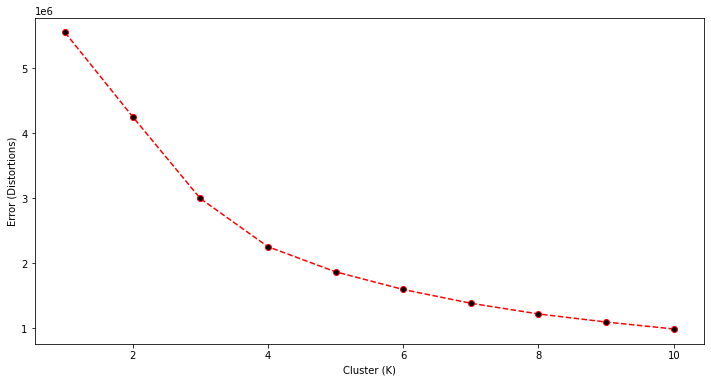

In [137]:
# Elbow Method for Finding Best Cluster

error = []
for i in range(1,11):
    km = KMeans(n_clusters=i,random_state=10)
    km.fit_predict(scaled_df)
    error.append(km.inertia_)
    
plt.figure(figsize=(12,6))
plt.plot(range(1,11),error,marker='o',ls='--',color='red',mfc='black')
plt.xlabel('Cluster (K)')
plt.ylabel('Error (Distortions)')
plt.show()

In [138]:
# Model Building
model_1 = KMeans(n_clusters=4,random_state=22)

In [139]:
# Fitting Data
model_1.fit(scaled_df)

KMeans(n_clusters=4, random_state=22)

In [140]:
# Centroids
centroids = model_1.cluster_centers_
centroids_df = pd.DataFrame(centroids,columns=list(scaled_df))
centroids_df

recency  frequency   monetary
0 -0.404032   1.547385   2.392711
1 -0.330126  -0.106037  -0.166799
2 -0.783408  17.847422  13.191699
3  2.017810  -0.201537  -0.177650

In [141]:
# Cluster Labels
label_df = pd.DataFrame(model_1.labels_,columns=['labels'])
label_df.head()

labels
0       1
1       1
2       1
3       1
4       1

In [142]:
# Adding Labels to Data Frame
scaled_df['labels'] = label_df['labels'].values

In [143]:
# Data Head
scaled_df.head()

recency  frequency  monetary  labels
reviewerID                                                  
A0000726154QG4JYYPS1W -0.681653  -0.258189 -0.272911       1
A000096617D1KX8J1SNO6 -0.431311  -0.258189  0.446752       1
A000152835L65OOF6JM10 -0.436455  -0.258189 -0.334782       1
A000187635I595IAVSQLH -0.664506   0.164322 -0.438987       1
A00024081MYZENMKQF9NC -0.873697  -0.258189 -0.498876       1

In [144]:
# Replacing Names of Clusters
scaled_df['labels'] = scaled_df['labels'].replace({0:'Promising',1:'Need-Attention',2:'Best-Customer',3:'Churn-Out'})

<Figure size 576x576 with 0 Axes>

Text(0.5, 1.0, 'Recency VS Frequency')

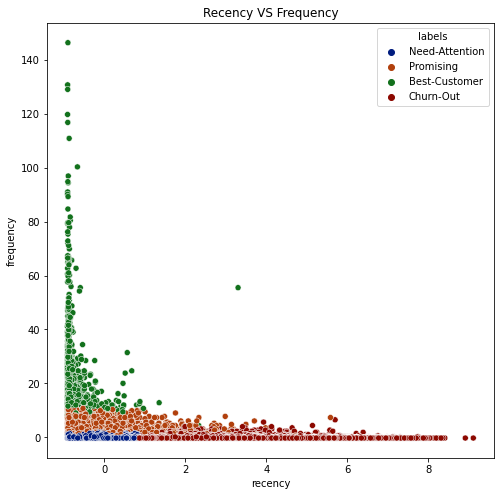

In [145]:
# Recency VS Frequency
plt.figure(figsize=(8,8))
sb.scatterplot(x ='recency',y = 'frequency',data = scaled_df, hue='labels', palette='dark')
plt.title('Recency VS Frequency')
plt.show()

<Figure size 576x576 with 0 Axes>

Text(0.5, 1.0, 'Recency VS Monetary')

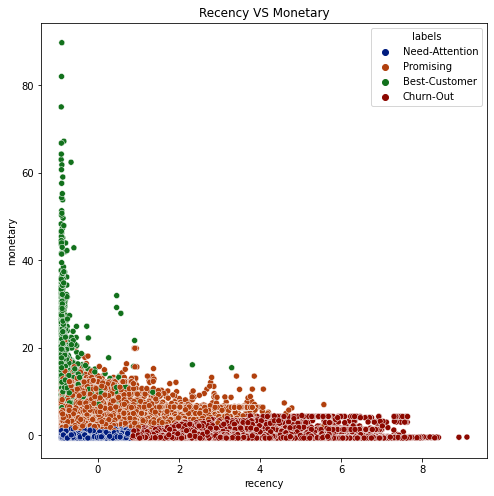

In [146]:
# Recency VS Monetary
plt.figure(figsize=(8,8))
sb.scatterplot(x ='recency',y = 'monetary',data = scaled_df, hue='labels', palette='dark')
plt.title('Recency VS Monetary')
plt.show()

# Product Recommendation

In [47]:
from sklearn.decomposition import TruncatedSVD

In [34]:
# Review Data Head
review_health.head(2)

reviewerID        asin    reviewerName helpful  \
0  ARMDSTEI0Z7YW  0077614992            dodo  [0, 0]   
1  A3FYN0SZYWN74  0615208479  Marilyn Mitzel  [0, 0]   

                                          reviewText  overall  \
0  This book was a requirement for a college clas...      5.0   
1  This is a great gift for anyone who wants to h...      5.0   

                         summary  unixReviewTime   reviewTime  
0                          great      1360886400  02 15, 2013  
1  AMAZING HOW QUICKLY IT WORKS!      1228089600   12 1, 2008

In [35]:
# Rating Details
rating = review_health.overall.unique()
print('Ratings: ',rating)
print('Len of Ratings: ',len(rating))

Ratings:  [5. 2. 4. 1. 3.]
Len of Ratings:  5


In [36]:
# Reviewer ID Details
id = review_health.reviewerID.unique()
print('Reviewer ID: ',id)
print('Len of Reviewer ID: ',len(id))

Reviewer ID:  ['ARMDSTEI0Z7YW' 'A3FYN0SZYWN74' 'A2J0WRZSAAHUAP' ... 'A1252ETWUJRKVC'
 'A215W0EOUNL81C' 'A2ZFFXGLJUHD76']
Len of Reviewer ID:  1851132


In [37]:
# Product ID
pro = review_health.asin.unique()
print('Products: ',pro)
print('Len of Products: ',len(pro))

Products:  ['0077614992' '0615208479' '0615269990' ... 'B00LV4480W' 'B00LWTTO0A'
 'B00LYPUPZK']
Len of Products:  252331


In [38]:
# Product which were sold more 
product_sales = review_health.groupby('asin')['overall'].count().sort_values(ascending=False)
product_sales.head()

asin
B001KXZ808    11365
B0032TNPOE     9338
B0095PZHPE     6788
B00B5H5BGA     5739
B0000U1OCI     5550
Name: overall, dtype: int64

In [39]:
# Reviewer written more 
rev_sales = review_health.groupby('reviewerID')['overall'].count().sort_values(ascending=False)
rev_sales.head()

reviewerID
A3OXHLG6DIBRW8    348
A1P27BGF8NAI29    311
A3NHUQ33CFH3VM    307
A1UQBFCERIP7VJ    285
A34BZM6S9L7QI4    278
Name: overall, dtype: int64

In [40]:
# Filtering the Data which has more than 50 items sold
new_df=review_health.groupby("asin").filter(lambda x:x['overall'].count() >= 50)

In [41]:
# Data Head
new_df.head()

reviewerID        asin              reviewerName helpful  \
350  A1LFEMC0GGOJ3X  159985130X                    7 Zion  [1, 1]   
351  A17NW9ZCVHYBS1  159985130X           Amazon Customer  [2, 2]   
352   AA5OQ4JR4CCV3  159985130X  Amazon Customer "Timmyg"  [1, 1]   
353   A1HP21ZBOYRSU  159985130X                Amazonmama  [2, 2]   
354   ALC5GH8CAMAI7  159985130X                      AnnN  [1, 1]   

                                            reviewText  overall  \
350  We recommend the Magnifier. We are able to rea...      4.0   
351  So convenient and small.  I love the LED light...      5.0   
352  Thank god for Amazon. I can never find things ...      5.0   
353  I just love this little gadget. Sometimes my r...      5.0   
354  This is a great little gadget to have around. ...      5.0   

                                               summary  unixReviewTime  \
350  The Lightwedge Lighted Pocket Magnifier meets ...      1353715200   
351                                        Convenient!      1279929600   
352                                   A real lifesaver      1268784000   
353                                Just what I needed!      1301270400   
354                                Handy little gadget      1294185600   

      reviewTime  
350  11 24, 2012  
351  07 24, 2010  
352  03 17, 2010  
353  03 28, 2011  
354   01 5, 2011

In [42]:
# Structure of Dataset
new_df.shape

(1731327, 9)

In [43]:
# Slicing the Data 
new_df_1 = new_df[:100000]

In [44]:
# Creating Pivot table for Checking Correlation
rating_matrix = new_df_1.pivot_table(index='asin',columns='reviewerID',values='overall',fill_value=0)

In [45]:
# Data Head
rating_matrix.head()

reviewerID  A0009478CBXKUCALUC7U  A005011233SVRED9Q0VY0  A00878297VYRVLFM06AG  \
asin                                                                            
159985130X                     0                      0                     0   
1933622865                     0                      0                     0   
3812028492                     0                      0                     0   
6182055936                     0                      0                     0   
7884890364                     0                      0                     0   

reviewerID  A00951093TVGQWA8EA8DB  A015565634RZNSDLJBE5M  \
asin                                                       
159985130X                      0                      0   
1933622865                      0                      0   
3812028492                      0                      0   
6182055936                      0                      0   
7884890364                      0                      0   

reviewerID  A01811021PZ9TH392P21J  A01818243PXJHK1ZH4HUM  \
asin                                                       
159985130X                      0                      0   
1933622865                      0                      0   
3812028492                      0                      0   
6182055936                      0                      0   
7884890364                      0                      0   

reviewerID  A01836621IAABVFLY7Z80  A01866161OQ1BJPZE8D00  \
asin                                                       
159985130X                      0                      0   
1933622865                      0                      0   
3812028492                      0                      0   
6182055936                      0                      0   
7884890364                      0                      0   

reviewerID  A0193442L7IJXD7HANDM  ...  AZZCT56PUXILB  AZZDHYOZS7M3B  \
asin                              ...                                 
159985130X                     0  ...              0              0   
1933622865                     0  ...              0              0   
3812028492                     0  ...              0              0   
6182055936                     0  ...              0              0   
7884890364                     0  ...              0              0   

reviewerID  AZZGJ2KMWB7R  AZZMINCJAD6JM  AZZMO52V8WZ68  AZZNK89PXD006  \
asin                                                                    
159985130X             0              0              0              0   
1933622865             0              0              0              0   
3812028492             0              0              0              0   
6182055936             0              0              0              0   
7884890364             0              0              0              0   

reviewerID  AZZTH6DJ0KSIP  AZZV9PDNMCOZW  AZZY3B308E3UB  AZZYO4XQYE89O  
asin                                                                    
159985130X              0              0              0              0  
1933622865              0              0              0              0  
3812028492              0              0              0              0  
6182055936              0              0              0              0  
7884890364              0              0              0              0  

[5 rows x 94786 columns]

In [46]:
# Structure of Pivot Table
rating_matrix.shape

(575, 94786)

In [48]:
# Dimensionality Reduction
svd = TruncatedSVD(n_components=20)
dim_data = svd.fit_transform(rating_matrix)

In [49]:
# Structure of SVD Data
dim_data.shape

(575, 20)

In [50]:
# Correlation Matrix
corr_matrix = np.corrcoef(dim_data)

In [51]:
# Shape of Correlation Matrix
corr_matrix.shape

(575, 575)

In [52]:
# Taking Random Product for Selection
i = rating_matrix.index[350]

In [53]:
# Displaying the Selected Product ID
i

'B0000Y3F6W'

In [54]:
# Taking Correlation Matrix Index into List
lst = list(rating_matrix.index)

In [55]:
# Finding Index of Selected Product ID in List
j = lst.index(i)

In [56]:
# Selection of Columns of Index of Product ID
correlation_product_ID = corr_matrix[j]

In [60]:
# Fetching Correlated Product ID's

Recommend = list(rating_matrix.index[correlation_product_ID > 0.8])

Recommend.remove(i) 

In [62]:
print(Recommend)

['3812028492', 'B00009RB1C', 'B0001ATEJ2']


# Time Series Demand Forecasting

In [79]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import statsmodels.api as sm
import math
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings('ignore')

In [80]:
# Head
data.head(2)

reviewerID        asin                        reviewerName  \
reviewTime                                                                   
1998-07-26  A2712X75Y9QI0Q  B0000017QN  Bruce L. Weaver (weav@waveone.net)   
1998-11-18  A2NKS9JA830F85  B000000EIC                      John A. Wilson   

             helpful  help_per  \
reviewTime                       
1998-07-26    [7, 9]     77.78   
1998-11-18  [16, 17]     94.12   

                                                   reviewText  overall  \
reviewTime                                                               
1998-07-26  I have an incurable addition to this music. I ...        5   
1998-11-18  I met and sang with Pat before he made his fir...        5   

           sentiment        summary  unixReviewTime reviewTime  \
reviewTime                                                       
1998-07-26  Positive  Magical Music       901411200 1998-07-26   
1998-11-18  Positive     wonderful!       911347200 1998-11-18   

                                                  description         title  \
reviewTime                                                                    
1998-07-26                                                     Sedona Suite   
1998-11-18  Vanguard is finally re-issuing this '60s folki...   Patrick Sky   

                                                        imUrl  \
reviewTime                                                      
1998-07-26  http://ecx.images-amazon.com/images/I/51riGHIG...   
1998-11-18  http://ecx.images-amazon.com/images/I/51X6YAX7...   

                                                      related  \
reviewTime                                                      
1998-07-26  {'also_bought': ['B0000017RN', 'B00000DBWN', '...   
1998-11-18  {'also_bought': ['B000003TK9', 'B000000XF7', '...   

                   salesRank                              categories  price  \
reviewTime                                                                    
1998-07-26  {'Music': 96262}      [CDs & Vinyl, New Age, Meditation]  15.67   
1998-11-18  {'Music': 44009}  [CDs & Vinyl, Folk, Contemporary Folk]  12.76   

                                             brand  
reviewTime                                          
1998-07-26  Soundings of the Planet, Healing Music  
1998-11-18                                     NaN

In [81]:
# Datatypes
data.dtypes

reviewerID                object
asin                      object
reviewerName              object
helpful                   object
help_per                 float64
reviewText                object
overall                    int64
sentiment                 object
summary                   object
unixReviewTime             int64
reviewTime        datetime64[ns]
description               object
title                     object
imUrl                     object
related                   object
salesRank                 object
categories                object
price                    float64
brand                     object
dtype: object

In [82]:
# Info
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2982326 entries, 1998-07-26 to 2014-07-23
Data columns (total 19 columns):
 #   Column          Dtype         
---  ------          -----         
 0   reviewerID      object        
 1   asin            object        
 2   reviewerName    object        
 3   helpful         object        
 4   help_per        float64       
 5   reviewText      object        
 6   overall         int64         
 7   sentiment       object        
 8   summary         object        
 9   unixReviewTime  int64         
 10  reviewTime      datetime64[ns]
 11  description     object        
 12  title           object        
 13  imUrl           object        
 14  related         object        
 15  salesRank       object        
 16  categories      object        
 17  price           float64       
 18  brand           object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(14)
memory usage: 455.1+ MB


In [83]:
# Columns
data.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'help_per',
       'reviewText', 'overall', 'sentiment', 'summary', 'unixReviewTime',
       'reviewTime', 'description', 'title', 'imUrl', 'related', 'salesRank',
       'categories', 'price', 'brand'],
      dtype='object')

In [84]:
# Decomposing Data Function
def time_series_comp(data):
  decomp = seasonal_decompose(data,period=12)
  trend = decomp.trend
  season = decomp.seasonal
  irreg = decomp.resid
  return(trend,season,irreg)

In [85]:
# Function for Time Series Components
def plot_comp(actual,trend,season,irreg,name):

  plt.figure(figsize=(20,20))
  plt.subplot(4,1,1)
  xx = plt.plot(actual,color='black')
  plt.title(name+' Actual Data',fontsize=20,color="maroon",fontweight=20)

  plt.figure(figsize=(20,20))
  plt.subplot(4,1,1)
  yy = plt.plot(trend,color='blue')
  plt.title(name+' Trend',fontsize=20,color="maroon",fontweight=20)

  plt.figure(figsize=(20,20))
  plt.subplot(4,1,1)
  zz = plt.plot(season,color='green')
  plt.title(name+' Seasonality',fontsize=20,color="maroon",fontweight=20)

  plt.figure(figsize=(20,20))
  plt.subplot(4,1,1)
  aa = plt.plot(irreg,color='red')
  plt.title(name+' Irregularity',fontsize=20,color="maroon",fontweight=20)

  return(xx,yy,zz,aa)

In [86]:
def stationarity_check(data):
  p_value = adfuller(data)[1]
  if p_value < 0.05:
    dec = 'Model was Stationary - Proceed for Model Building'
  else:
    dec = 'Model was not Stationary - Take Differenced Data'
  return(dec)

In [87]:
def plot(data):
  return(plot_acf(res_data_diff,c='red',lags=12),plot_pacf(res_data_diff,c='red',lags=12));

In [88]:
def trend_order_iter(p,d,q):
  lst = []
  for i in range(p+1):
    for j in range(q+1):
      lst.append((i,0,j))
  return(lst)

def seasonal_order_iter(P,D,Q,L):
  lst = []
  for i in range(P+1):
    for j in range(Q+1):
      lst.append((i,D,j,L))
  return(lst)

def score_cal_1(t_lst,s_lst,data):
  AIC = []
  BIC = []
  MSE = []
  RMSE = []
  for i in t_lst:
    for j in s_lst:
      model = sm.tsa.statespace.SARIMAX(data,order=i,seasonal_order=j).fit()
      pred = model.fittedvalues
      AIC.append(model.aic)
      BIC.append(model.bic)
      MSE.append(round(metrics.mean_squared_error(data,pred),3))
      RMSE.append(round(metrics.mean_squared_error(data,pred,squared=False),3))
  c = pd.DataFrame({'AIC':AIC,'BIC':BIC,'MSE':MSE,'RMSE':RMSE},index=lst)
  print('Min AIC Order: ',c['AIC'].idxmin())
  print('Min BIC Order: ',c['BIC'].idxmin())
  print('Min MSE Order: ',c['MSE'].idxmin())
  print('Min RMSE Order: ',c['RMSE'].idxmin())

In [89]:
# Ljung Box Test 
def fit_check(model):
    pvalue = sm.stats.acorr_ljungbox(model.resid,lags=[12],return_df=True)['lb_pvalue'].values
    if pvalue < 0.05:
        print("Bad model - Build the Model Again with differnt Parameters")
    else:
        print("Good model - Proceed for Forecasting")

In [90]:
def error_check(data,forecast):
    mse = round(metrics.mean_squared_error(data,forecast),3)
    rmse = round(metrics.mean_squared_error(data,forecast,squared=False),3)
    mae = round(metrics.mean_absolute_error(data,forecast),3)
    mape = round(metrics.mean_absolute_percentage_error(data,forecast),3)
    return(mse,rmse,mae,mape)

def print_error(m1_mse, m1_rmse, m1_mae, m1_mape, Model):
    print('Mean Squared Error of '+Model+' is: ',m1_mse)
    print('Root Mean Squared Error of '+Model+' is: ',m1_rmse)
    print('Mean Absolute Error of '+Model+' is: ',m1_mae)
    print('Mean Absolute Percentage Error of '+Model+' is: ',m1_mape)
    
def aic_bic_scores(model):
    AIC = round(model.aic,3)
    BIC = round(model.bic,3)
    return(AIC,BIC)

def print_aic_bic(AIC, BIC, Model):
    print('AIC Score '+Model+' is: ',AIC)
    print('BIC Score '+Model+' is: ',BIC)

## EatSmart Precision Digital Bathroom Scale w/ Extra Large Lighted Display, 400 lb. Capacity and &quot;Step-On&quot; Technology [2014 VERSION] - 10,000+ Reviews EatSmart Guaranteed Accurate

In [91]:
# Copying Data
df_1 = data.copy()

In [92]:
# Products which are sold more
df_1.title.value_counts()

EatSmart Precision Digital Bathroom Scale w/ Extra Large Lighted Display, 400 lb. Capacity and &quot;Step-On&quot; Technology [2014 VERSION] - 10,000+ Reviews EatSmart Guaranteed Accurate    11365
Eatsmart Precision Plus Digital Bathroom Scale with Ultra Wide Platform and Step-on Technology, 440-Pounds                                                                                      9338
Fitbit One Wireless Activity Plus Sleep Tracker, Black                                                                                                                                          6788
NatureWise Garcinia Cambogia Extract Natural Appetite Suppressant and Weight Loss Supplement, 180 Count, 500mg (packaging may vary)                                                             5739
Omron HJ-112 Digital Pocket Pedometer                                                                                                                                                           5550
               

In [93]:
# Mask the Data
mask = (df_1['reviewTime'] > '2008-1-1') & (df_1['reviewTime'] <= '2013-12-31')
df_1 = df_1.loc[mask]

In [94]:
# Data Filtering
data_1 = df_1.loc[df_1.title == 'EatSmart Precision Digital Bathroom Scale w/ Extra Large Lighted Display, 400 lb. Capacity and &quot;Step-On&quot; Technology [2014 VERSION] - 10,000+ Reviews EatSmart Guaranteed Accurate','title']

In [95]:
# Resampling the Data
res_data = data_1.resample('M').count()

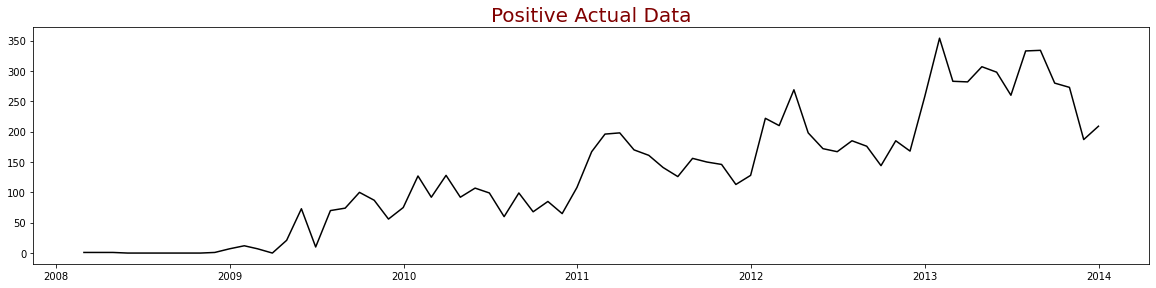

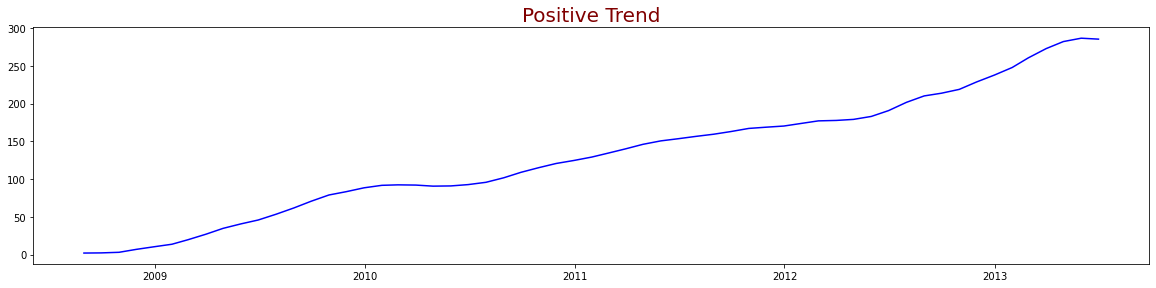

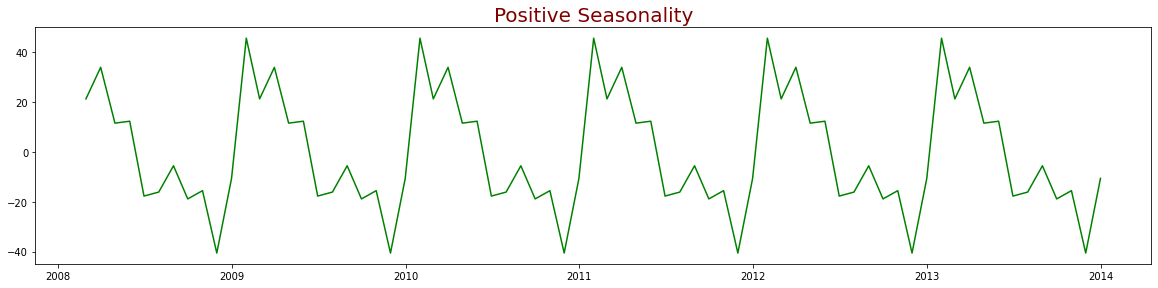

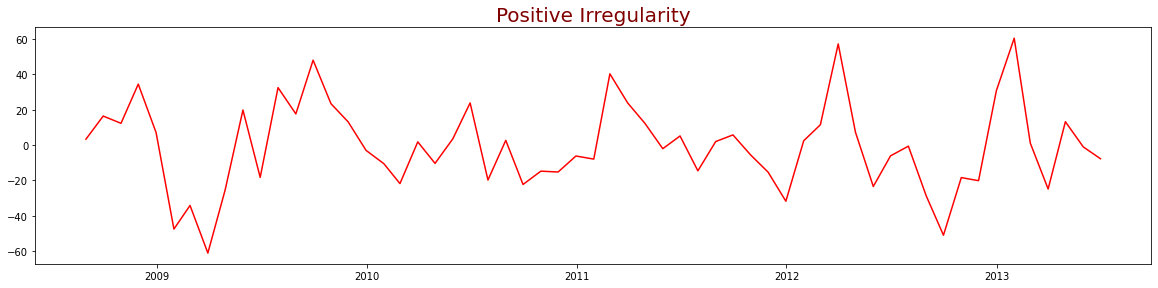

In [96]:
# Positive Time Series Data Components
trend, season, irreg = time_series_comp(res_data)

plot_comp(res_data,trend,season,irreg,'Positive')
plt.show();

In [97]:
# Stationary Check
stationarity_check(res_data)

'Model was not Stationary - Take Differenced Data'

In [98]:
# Differencing Data
res_data_diff = res_data - res_data.shift(1)
res_data_diff.dropna(inplace=True)

In [99]:
# Stationary Check
stationarity_check(res_data_diff)

'Model was Stationary - Proceed for Model Building'

(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

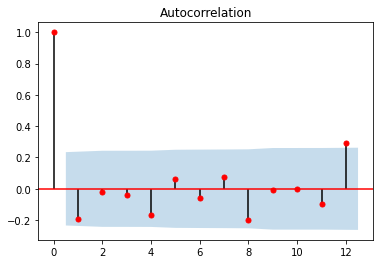

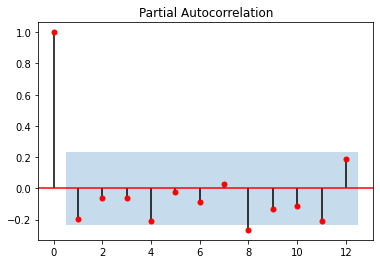

In [100]:
# Plotting ACF and PACF
plot(res_data_diff)

In [101]:
# Splitting Data
sep = int(res_data.shape[0]*0.8)

train = res_data[:sep+1]
test = res_data[sep:]

In [102]:
# Model Building 
model_1 = sm.tsa.statespace.SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,12)).fit()

In [103]:
# Fit Check
fit_check(model_1)

Good model - Proceed for Forecasting


In [104]:
# Forecasting the Data
pred = model_1.forecast(len(test)+30)

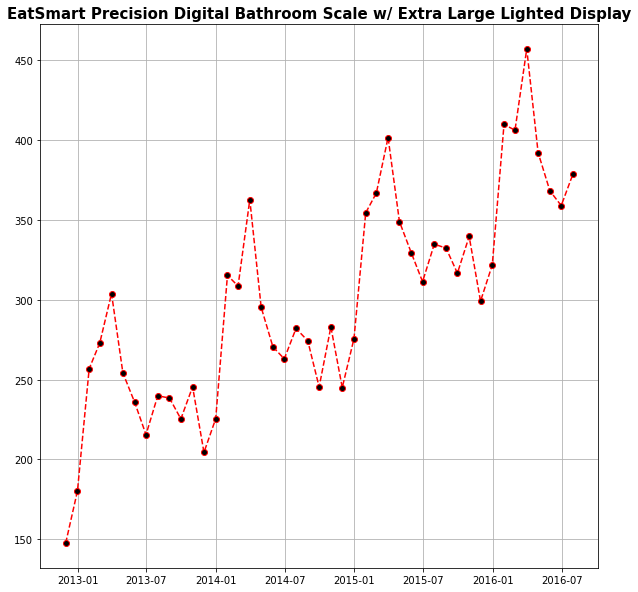

In [105]:
# Plotting Data
plt.figure(figsize=(10,10))
plt.plot(pred,ls='--',marker='o',mfc='black',color='red')
plt.title('EatSmart Precision Digital Bathroom Scale w/ Extra Large Lighted Display',fontsize=15,fontweight = 'bold')
plt.grid()
plt.show();

## Eatsmart Precision Plus Digital Bathroom Scale with Ultra Wide Platform and Step-on Technology, 440-Pounds

In [106]:
# Copying Data
df_1 = data.copy()

In [107]:
# Products which are sold more
df_1.title.value_counts()

EatSmart Precision Digital Bathroom Scale w/ Extra Large Lighted Display, 400 lb. Capacity and &quot;Step-On&quot; Technology [2014 VERSION] - 10,000+ Reviews EatSmart Guaranteed Accurate    11365
Eatsmart Precision Plus Digital Bathroom Scale with Ultra Wide Platform and Step-on Technology, 440-Pounds                                                                                      9338
Fitbit One Wireless Activity Plus Sleep Tracker, Black                                                                                                                                          6788
NatureWise Garcinia Cambogia Extract Natural Appetite Suppressant and Weight Loss Supplement, 180 Count, 500mg (packaging may vary)                                                             5739
Omron HJ-112 Digital Pocket Pedometer                                                                                                                                                           5550
               

In [108]:
# Mask the Data
mask = (df_1['reviewTime'] > '2008-1-1') & (df_1['reviewTime'] <= '2013-12-31')
df_1 = df_1.loc[mask]

In [109]:
# Data Filtering
data_1 = df_1.loc[df_1.title == 'Eatsmart Precision Plus Digital Bathroom Scale with Ultra Wide Platform and Step-on Technology, 440-Pounds','title']

In [110]:
# Resampling the Data
res_data = data_1.resample('M').count()

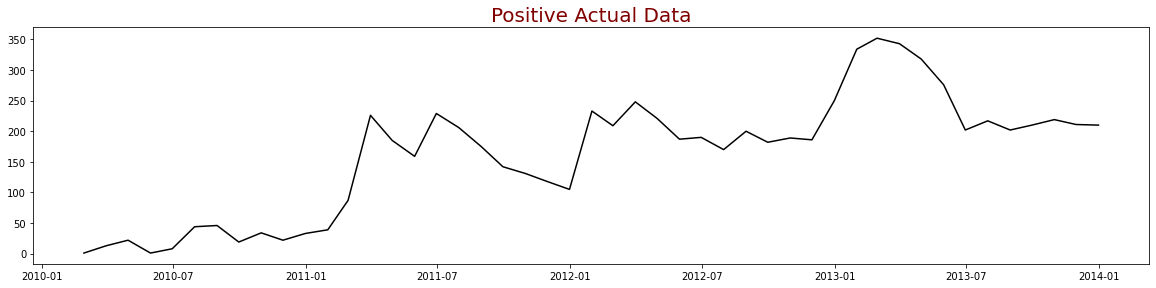

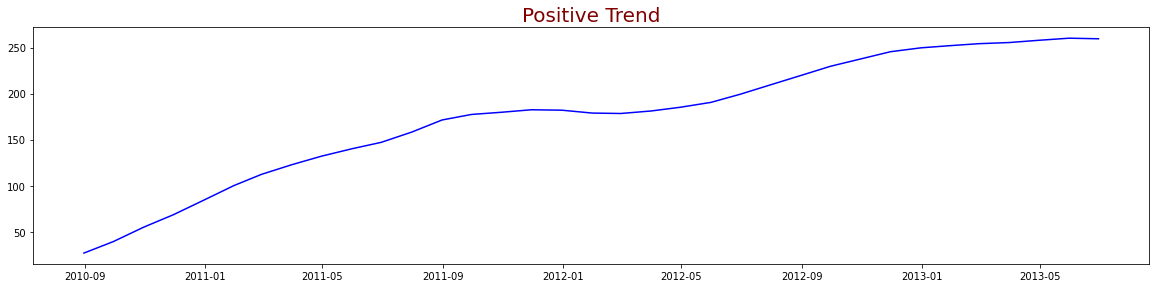

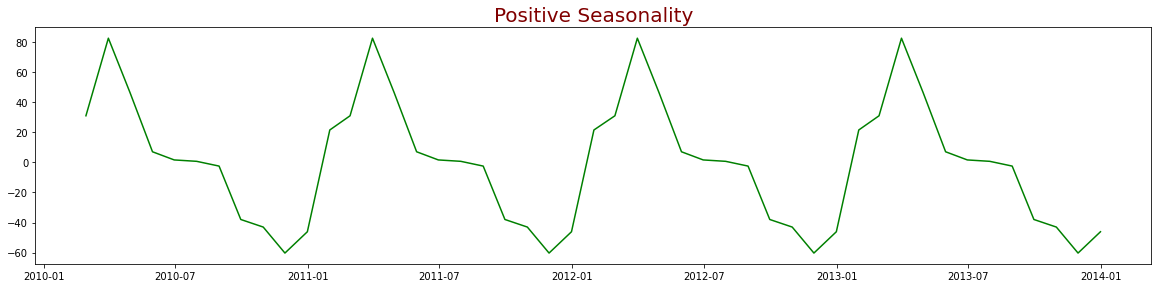

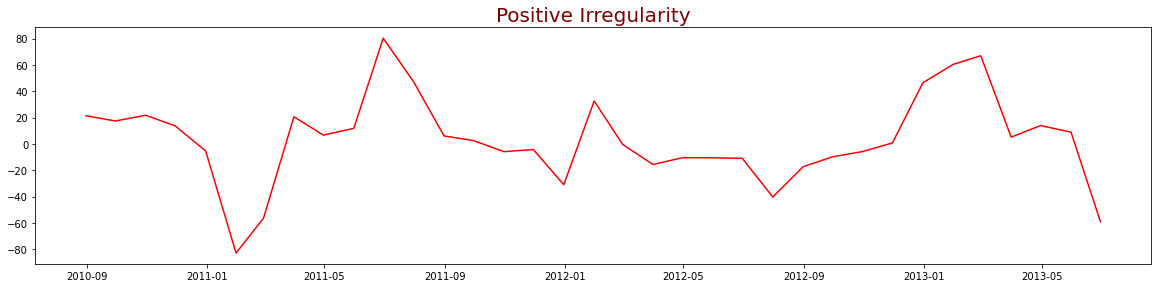

In [111]:
# Positive Time Series Data Components
trend, season, irreg = time_series_comp(res_data)

plot_comp(res_data,trend,season,irreg,'Positive')
plt.show();

In [112]:
# Stationary Check
stationarity_check(res_data)

'Model was not Stationary - Take Differenced Data'

In [113]:
# Differencing Data
res_data_diff = res_data - res_data.shift(1)
res_data_diff.dropna(inplace=True)

In [114]:
# Stationary Check
stationarity_check(res_data_diff)

'Model was Stationary - Proceed for Model Building'

(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

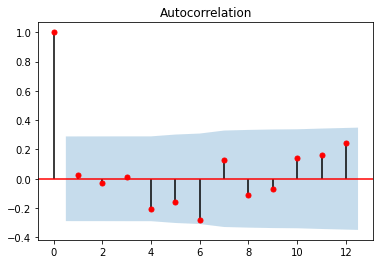

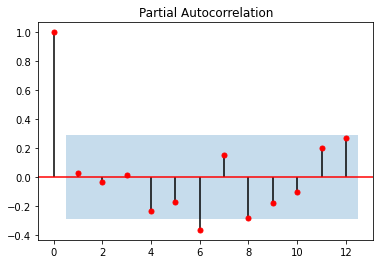

In [115]:
# Plotting ACF and PACF
plot(res_data_diff)

In [116]:
# Splitting Data
sep = int(res_data.shape[0]*0.8)

train = res_data[:sep+1]
test = res_data[sep:]

In [117]:
# Model Building 
model_2 = sm.tsa.statespace.SARIMAX(train,order=(1,1,0),seasonal_order=(1,1,0,12)).fit()

In [118]:
# Fit Check
fit_check(model_2)

Good model - Proceed for Forecasting


In [119]:
# Forecasting the Data
pred = model_2.forecast(len(test)+30)

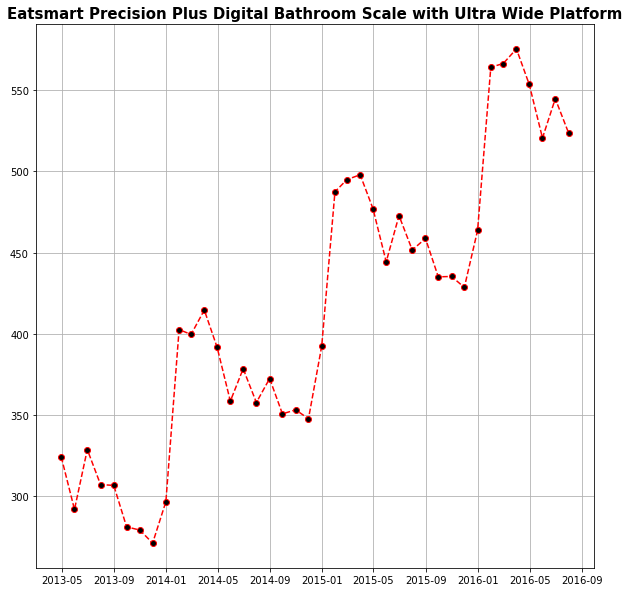

In [120]:
# Plotting Data
plt.figure(figsize=(10,10))
plt.plot(pred,ls='--',marker='o',mfc='black',color='red')
plt.title('Eatsmart Precision Plus Digital Bathroom Scale with Ultra Wide Platform',fontsize=15,fontweight = 'bold')
plt.grid()
plt.show();